In [150]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.aqua.utils.circuit_factory import CircuitFactory
from exp_a4 import A4Factory
from exp_a23 import A23Factory
from exp_a1 import A1Factory
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from scipy.linalg import expm
%matplotlib inline
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.circuits.gates import mct
# import FTSDFactory

In [151]:
class FTSDFactory(CircuitFactory):
    """
    When no time is provided the simulation runs for t=1. The target qubit is the less significant one.
    """
    def __init__(self, num_target_qubits=1):
        super().__init__(num_target_qubits)

    def required_ancillas(self):
        return 0

    def required_ancillas_controlled(self):
        return 0
    
    def build(self, qc, q, q_ancillas=None, params=1):
        pass
        # qc.u3(params, -np.pi/2, np.pi/2, q[0])

    def build_controlled(self, qc, q, q_control, q_ancillas=None, t=1, kj=1, coefficient = [], matrix_index = []):
        if len(coefficient) != len(matrix_index):
            exit("Error.")
        a1 = A1Factory(n)
        a23 = A23Factory(n)
        a4 = A4Factory(n)
        
        for j in range(kj):
          for i in range(len(matrix_index)):
              if matrix_index[i] == 0:
                  a1.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
              elif matrix_index[i]==1:
                  a23.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
              elif matrix_index[i]==2:
                  a4.build_controlled(qc, qr, q_control, q_ancillas, coefficient[i]*t/kj/2)
              else:
                  exit("Wrong matrix index: ", i)

    def build_inverse(self, qc, q, q_ancillas=None, params=1):
        pass
        # self.build(qc, q, q_ancillas, -params)

    def build_controlled_inverse(self, qc, q, q_control, q_ancillas=None, params=1):
        self.build_controlled(qc, q, q_control, q_ancillas, -params)

In [152]:
def inverseindexvector(vector):
    m = len(vector)
    invector = np.zeros(m-1)
    #Reorder the vector from m starting and ending with 1, we delete the first element of the vector!
    for i in range(m-1):
        invector[i] = vector[m-i-1] 
    return invector
    

def TS_matrixindex(indexvector, coefficientvector, trotterstepsize):
    M = trotterstepsize
    m = len(indexvector)-1
    trottervector = [] #Naming is irrelevant to meaning
    suzukivector = [] #Naming is irrelevant to meaning
    repvector = np.zeros(2*m-1)
    rep2vector = np.zeros(2*m-1)
    
    #The first value is the same as the index vector
    trottervector = np.append(trottervector, indexvector[0])
    suzukivector = np.append(suzukivector, coefficientvector[0])
    opvector = inverseindexvector(indexvector)
    op2vector = inverseindexvector(coefficientvector)
    #Inside the Repetition (~~~)^M
    for i in range(m):
        repvector[i]=indexvector[i+1]
        rep2vector[i]=coefficientvector[i+1]
        
    for i in range(m):
        repvector[m+i-1]=opvector[i]
        rep2vector[m+i-1]=op2vector[i]
        
    print(repvector)
    for i  in range(M):
        trottervector = np.append(trottervector, repvector)
        suzukivector = np.append(suzukivector, rep2vector)
    return (trottervector, suzukivector)

In [153]:
# number of qubits n, where size of the matrix is 2**n
n = 2
#Some other parameters
t = 1 #Time
m =  3 #Trotter Steps

# number of ancilla qubits for the unitary operations themselves
n_ancilla = n-1
# number of ancilla qubits for controlling the unitary operations
n_a_con = 1

qr = QuantumRegister(n)
qra =  QuantumRegister(n_ancilla)
qrac = QuantumRegister(n_a_con)
cr = ClassicalRegister(n+n_ancilla+n_a_con)

qc = QuantumCircuit(qr, qra, qrac, cr)

# vector for the parameters of the matrices
coefficientmatrix=[1,2,3,4,5,6]

#vector for the type of matrix to calculate
inputmatrix=[1,2,2,0,2,1]

#calculate matrix index for m Trotter steps
(matrix_index, coefficient) = TS_matrixindex(inputmatrix, coefficient, m)
print(matrix_index)
print(coefficient)

[2. 2. 0. 2. 1. 2. 0. 2. 2.]
[1. 2. 2. 0. 2. 1. 2. 0. 2. 2. 2. 2. 0. 2. 1. 2. 0. 2. 2. 2. 2. 0. 2. 1.
 2. 0. 2. 2.]
[1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 2. 3. 4. 5. 2. 3. 4. 5. 6. 2. 3. 4. 5. 2.
 3. 4. 5. 6.]


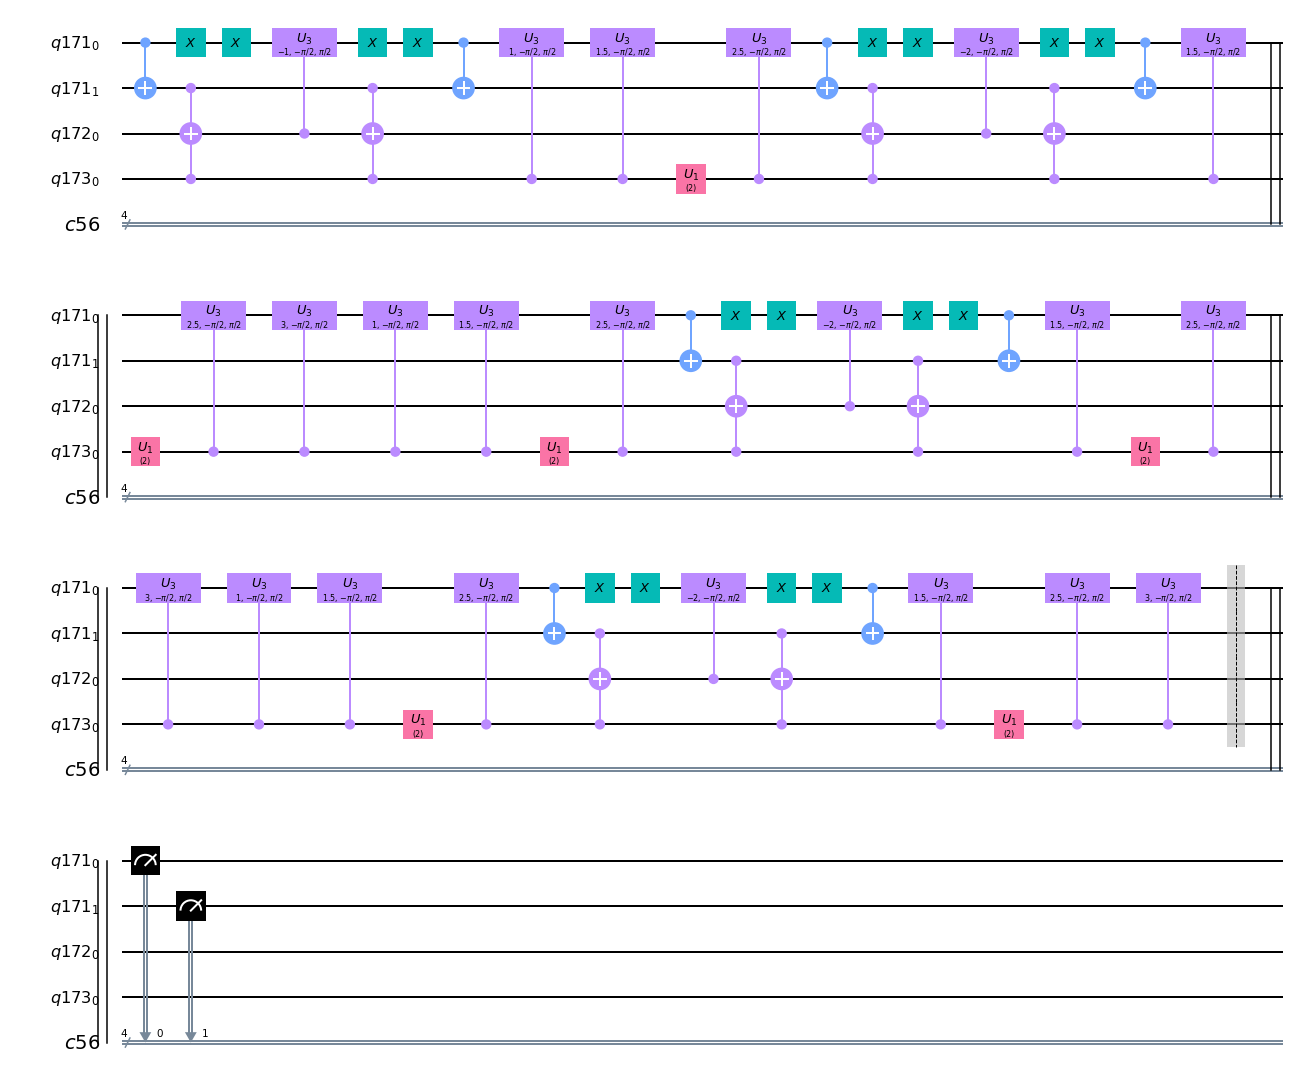

In [154]:
FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=t, kj=1, coefficient=coefficient, matrix_index=matrix_index)
qc.barrier()
qc.measure(qr, cr[0:n])
qc.draw(output='mpl')